# 1. Import libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

# From here, add any libraries that you might need for the rest of your code
import random
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support

from tensorflow.keras.applications import ResNet50, VGG16, DenseNet121
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_pre
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_pre
from tensorflow.keras.applications.densenet import preprocess_input as densenet_pre

# 2. Load and pre-process the dataset

In [2]:
# set this path to the directory where you stored the dataset
dataset_dir = "data/Train" 

# LIST THE CLASSES THAT EXIST WITHIN THIS DATASET:
CLASS_LABELS  = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC'] # creates a list of the 8 classes in this dataset (the dataset contains images of 8 types of skin lesion)
# note: class names are abbreviations for:
# ["Actinic Keratoses", "Basal Cell Carcinoma", "Benign Keratosis-like Lesions", "Dermatofibroma", "Melanoma", "Nevus", "Squamous Cell Carcinoma", "Vascular Lesions"]


In [3]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# LOAD AND PREPROCESS THE DATA:

# set size of images (in pixels) after resizing
IMG_HEIGHT = 42
IMG_WIDTH = 42

# set batch size
BATCH_SIZE = 128

# set relative sizes of the test and val set
TEST_SIZE = 0.2   # 20% of all 27.934 images will be used for testing the model
VAL_SIZE = 0.2    # of the remaining images, 20% will be used for validation and 80% for training

# function for adding noise to the images
def add_noise(img):
    std_coeff = 20 * np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    img = np.clip(img, 0., 255.)
    return img

# build dataframe with file paths and labels
all_files = []
all_labels = []

for class_name in sorted(os.listdir(dataset_dir)):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            all_files.append(fpath)
            all_labels.append(class_name)

df = pd.DataFrame({"filename": all_files, "class": all_labels})

# split the data into train / val / test
trainval_df, test_df = train_test_split(df, test_size=TEST_SIZE, stratify=df["class"], random_state=31) # split all data into trainval + test
train_df, val_df   = train_test_split(trainval_df, test_size=VAL_SIZE, stratify=trainval_df["class"], random_state=31)  # split trainval data into train + val

# define generators
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise) # note: noise is only added to the train samples.
val_test_datagen = ImageDataGenerator(rescale=1./255)

# apply generators
train_data = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=7
)

val_data = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="class",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=7
)

test_data = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="class",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("Data loading completed successfully.")
print(f"Number of training samples: {train_data.samples}")
print(f"Number of validation samples: {val_data.samples}")
print(f"Number of test samples: {test_data.samples}")
print(f"Class names: {train_data.class_indices}")

Found 17877 validated image filenames belonging to 8 classes.
Found 4470 validated image filenames belonging to 8 classes.
Found 5587 validated image filenames belonging to 8 classes.
Data loading completed successfully.
Number of training samples: 17877
Number of validation samples: 4470
Number of test samples: 5587
Class names: {'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}


## 2.2 Configuration & Reproducibility
Set seeds.

In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
NUM_CLASSES = len(CLASS_LABELS)

# 3. Visualise data and plot data distribution

### 3.1 Functions

In [38]:
def show_random_grid(generator, n=15, cols=5, seed=SEED, title="Random samples"):
    """
    Display n random images with labels from a Keras generator that uses flow_from_dataframe.
    Assumes generator has .filepaths, .classes, and .class_indices.
    """
    rnd = random.Random(seed)
    idxs = rnd.sample(range(len(generator.filepaths)), n)
    class_inv = {v: k for k, v in generator.class_indices.items()}
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols * 2.4, rows * 2.4))
    for i, idx in enumerate(idxs):
        # Load the raw image path and label
        path = generator.filepaths[idx]
        label_id = generator.classes[idx]
        label = class_inv[label_id]
        # Read image via keras utils
        img = tf.keras.utils.load_img(path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(label, fontsize=9)
    plt.suptitle(title, y=0.98)
    plt.tight_layout()
    plt.show()

def plot_class_distribution(generator, title="Class distribution"):
    classes = np.asarray(generator.classes)
    class_inv = {v: k for k, v in generator.class_indices.items()}
    labels = [class_inv[i] for i in sorted(set(classes))]
    counts = [int(np.sum(classes == i)) for i in range(len(labels))]
    plt.figure(figsize=(8, 4))
    plt.bar(labels, counts)
    plt.ylabel("Count")
    plt.title(title)
    for i, c in enumerate(counts):
        plt.text(i, c, str(c), ha='center', va='bottom', fontsize=8)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


### 3.2 Visualization

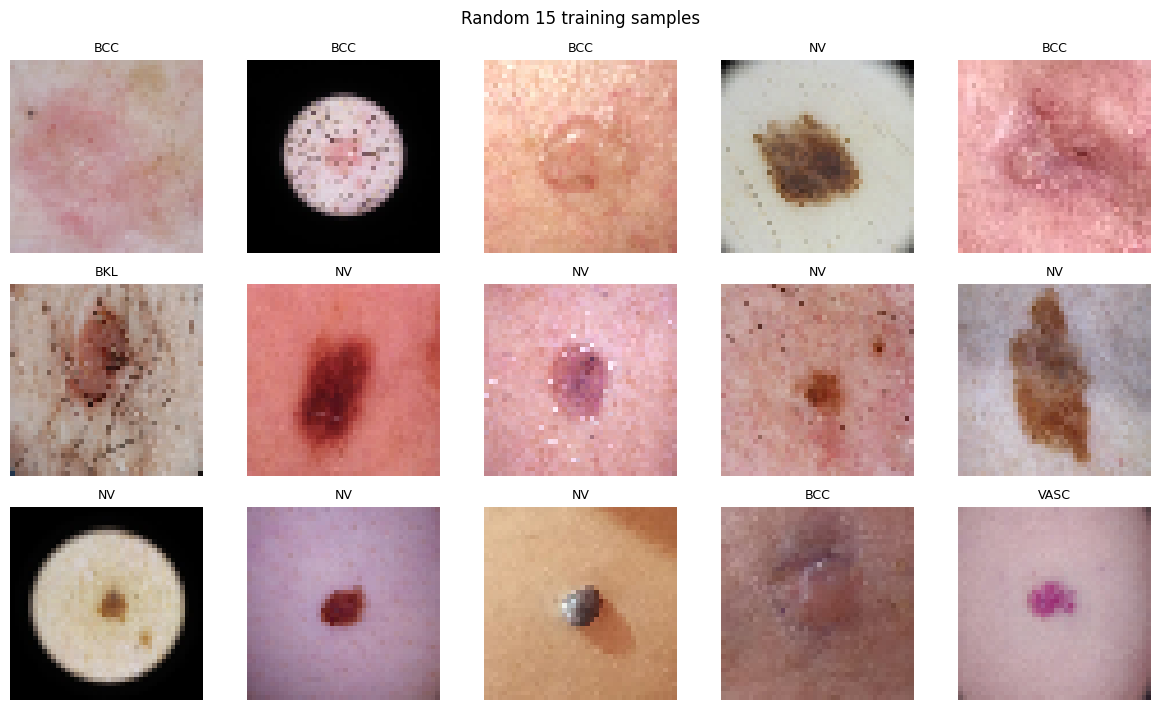

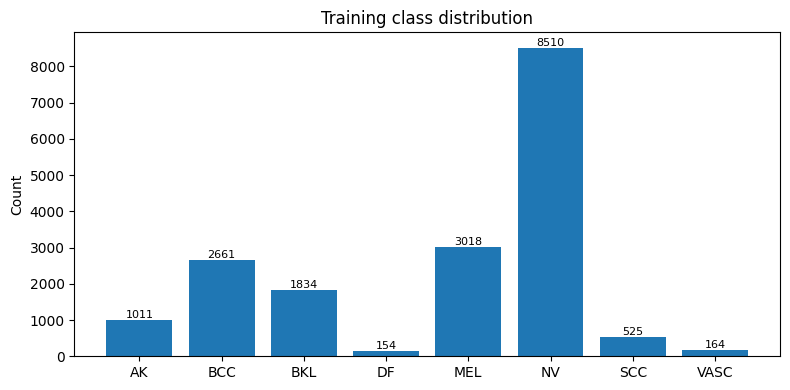

In [39]:
show_random_grid(train_data, n=15, cols=5, seed=SEED, title="Random 15 training samples")
plot_class_distribution(train_data, title="Training class distribution")

# 4. Common Functions

### 4.1 Traing helpers & history plots

In [40]:
def train_model(model, train_gen, val_gen, epochs=15, early_stopping=False):
    steps_per_epoch = int(np.ceil(train_gen.samples / train_gen.batch_size))
    val_steps = int(np.ceil(val_gen.samples / val_gen.batch_size))

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True))

    hist = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=val_steps,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    return hist


def plot_history(hist, title_prefix="Baseline"):
    h = hist.history
    epochs = range(1, len(h['loss']) + 1)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, h['loss'], label='train')
    plt.plot(epochs, h['val_loss'], label='val')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title(f"{title_prefix} Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, h['accuracy'], label='train')
    plt.plot(epochs, h['val_accuracy'], label='val')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title(f"{title_prefix} Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

### 4.2 Evaluation functions

In [ ]:
def _predict_generator(model, gen):
    """
    Run model.predict on a Keras generator and return (y_true, y_pred, y_prob).
    """
    steps = int(np.ceil(gen.samples / gen.batch_size))
    y_prob = model.predict(gen, steps=steps, verbose=0)
    y_true = gen.classes
    y_pred = np.argmax(y_prob, axis=1)
    return y_true, y_pred, y_prob


def plot_confusion(gen, y_true, y_pred, title="Confusion matrix"):
    """
    Confusion matrix with class labels taken from generator.class_indices.
    """
    class_inv = {v: k for k, v in gen.class_indices.items()}
    labels = [class_inv[i] for i in range(len(class_inv))]

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(title)
    plt.tight_layout(); plt.show()


def plot_multiclass_roc(gen, y_true, y_prob, title="ROC (one-vs-rest)"):
    """
    One-vs-rest ROC curves with micro and macro averages for multi-class.
    """
    class_inv = {v: k for k, v in gen.class_indices.items()}
    n_classes = len(class_inv)

    # Binarize true labels for OvR curves
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot
    plt.figure(figsize=(7, 6))
    class_names_ordered = [class_inv[i] for i in range(n_classes)]
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f"{class_names_ordered[i]} (AUC={roc_auc[i]:.3f})",
                 alpha=0.8)
    plt.plot(fpr["micro"], tpr["micro"],
             label=f"micro-average (AUC={roc_auc['micro']:.3f})",
             linestyle='--')
    plt.plot(fpr["macro"], tpr["macro"],
             label=f"macro-average (AUC={roc_auc['macro']:.3f})",
             linestyle='--')
    plt.plot([0, 1], [0, 1], linestyle=':')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title(title)
    plt.legend()
    plt.tight_layout(); plt.show()


def report_metrics(y_true, y_pred, average='macro'):
    """
    Prints and returns (accuracy, precision, recall, f1) for a given averaging scheme.
    """
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=average, zero_division=0
    )
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision ({average}): {prec:.4f}")
    print(f"Recall ({average}): {rec:.4f}")
    print(f"F1-score ({average}): {f1:.4f}")
    return acc, prec, rec, f1


def full_evaluation(model, gen, split_name="Test"):
    """
    Runs predictions, prints macro & weighted metrics, shows confusion matrix,
    plots multi-class ROC with micro/macro AUC, and prints a per-class report.
    """
    y_true, y_pred, y_prob = _predict_generator(model, gen)

    print(f"\n=== {split_name} metrics (macro) ===")
    report_metrics(y_true, y_pred, average='macro')

    print(f"\n=== {split_name} metrics (weighted) ===")
    report_metrics(y_true, y_pred, average='weighted')

    plot_confusion(gen, y_true, y_pred, title=f"{split_name} Confusion Matrix")
    plot_multiclass_roc(gen, y_true, y_prob, title=f"{split_name} ROC")

    print("\nClassification report (per-class):\n")
    class_inv = {v: k for k, v in gen.class_indices.items()}
    target_names = [class_inv[i] for i in range(len(class_inv))]
    print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

# 5. Baseline Model

### 5.1 Design
Two Conv blocks (3x3, 16 filters) each followed by MaxPool 2x2; Flatten; Dense 1600→128 (ReLU); Dense 128→8 (Softmax).

In [42]:
def build_baseline_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape)
    # Block 1
    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    # Block 2
    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    # Flatten → Dense 1600 → 128
    x = layers.Flatten()(x)
    x = layers.Dense(1600, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    # Output logits → Softmax
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs, name='BaselineCNN')
    return model

def compile_baseline(model, lr=1e-3):
    opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',  # use 'sparse_categorical_crossentropy' if you switch to integer labels
                  metrics=['accuracy'])
    return model

### 5.2 Train

In [46]:
baseline = build_baseline_model()
baseline = compile_baseline(baseline, lr=1e-3)
hist_baseline = train_model(baseline, train_data, val_data, epochs=15)

Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.5248 - loss: 1.3191 - val_accuracy: 0.5687 - val_loss: 1.1952 - learning_rate: 0.0010
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.5776 - loss: 1.1671 - val_accuracy: 0.5982 - val_loss: 1.1305 - learning_rate: 0.0010
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - accuracy: 0.5984 - loss: 1.1084 - val_accuracy: 0.6092 - val_loss: 1.0900 - learning_rate: 0.0010
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.6106 - loss: 1.0705 - val_accuracy: 0.6112 - val_loss: 1.0759 - learning_rate: 0.0010
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.6215 - loss: 1.0454 - val_accuracy: 0.6083 - val_loss: 1.0707 - learning_rate: 0.0010
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.6301 - loss: 1.0160 - val_accuracy: 0.6034 - val_loss: 1.0877 - learning_rate: 0.0010
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.6466 - l

### 5.3 Evaluation

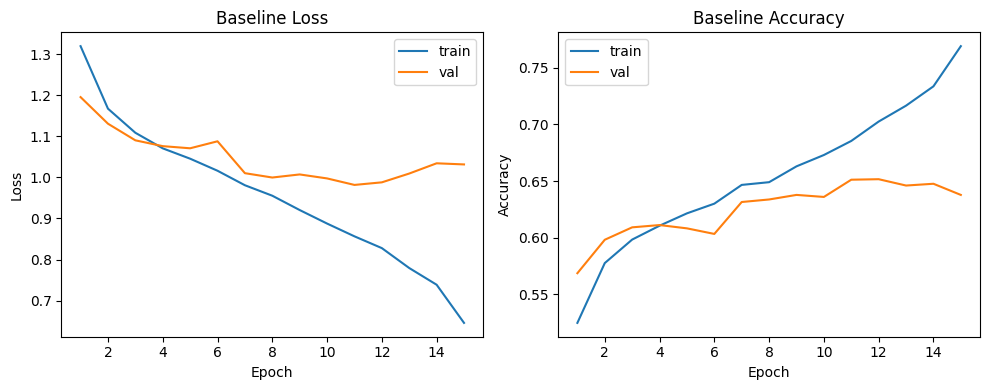

In [61]:
plot_history(hist_baseline, title_prefix="Baseline")


=== Validation metrics (macro) ===
Accuracy: 0.2962
Precision (macro): 0.1273
Recall (macro): 0.1297
F1-score (macro): 0.1277

=== Validation metrics (weighted) ===
Accuracy: 0.2962
Precision (weighted): 0.3036
Recall (weighted): 0.2962
F1-score (weighted): 0.2991


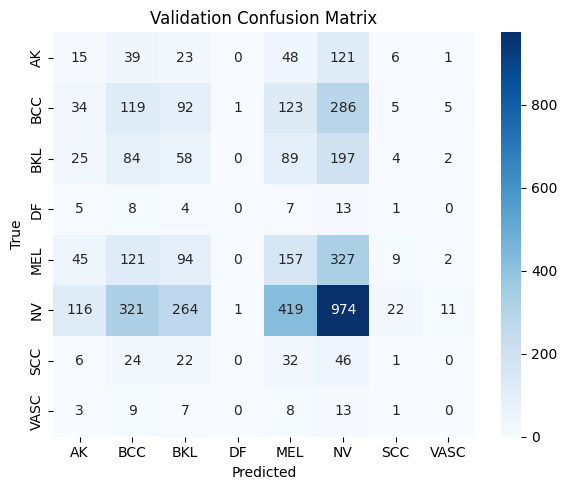

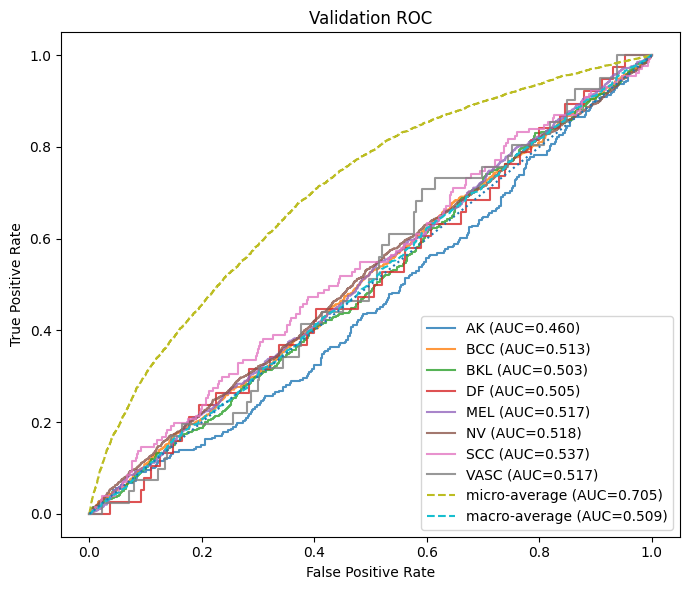


Classification report (per-class):

              precision    recall  f1-score   support

          AK       0.06      0.06      0.06       253
         BCC       0.16      0.18      0.17       665
         BKL       0.10      0.13      0.11       459
          DF       0.00      0.00      0.00        38
         MEL       0.18      0.21      0.19       755
          NV       0.49      0.46      0.47      2128
         SCC       0.02      0.01      0.01       131
        VASC       0.00      0.00      0.00        41

    accuracy                           0.30      4470
   macro avg       0.13      0.13      0.13      4470
weighted avg       0.30      0.30      0.30      4470



In [ ]:
full_evaluation(baseline, test_data, split_name="Test")

# 6. Improved model

### 6.1 Design

In [45]:
class ImprovedCNN(tf.keras.Model):
    """
    Flexible CNN with tunable depth/width/regularization for purposeful hyperparameter studies.
    Hyperparams:
      - base_filters: #filters in the first conv block (doubles each block)
      - blocks: number of conv blocks (Conv2D -> [BN] -> Act -> MaxPool)
      - dense_units: width of the first dense layer
      - dropout_rate: dropout after dense layer
      - use_bn: whether to use BatchNorm after convs and before dense activation
      - activation: activation function name (e.g., 'relu', 'gelu', 'leaky_relu' via layers.Activation)
    """
    def __init__(self, base_filters=32, blocks=3, dense_units=256,
                 dropout_rate=0.3, use_bn=True, activation='relu'):
        super().__init__()
        self.use_bn = use_bn
        self.activation = activation

        # Feature extractor
        self.features = []
        filters = base_filters
        for _ in range(blocks):
            self.features.append(layers.Conv2D(filters, (3, 3), padding='same'))
            if use_bn:
                self.features.append(layers.BatchNormalization())
            self.features.append(layers.Activation(activation))
            self.features.append(layers.MaxPooling2D((2, 2)))
            filters *= 2

        # Classifier head
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(dense_units)
        self.bn1 = layers.BatchNormalization() if use_bn else None
        self.act1 = layers.Activation(activation)
        self.drop = layers.Dropout(dropout_rate)
        self.out = layers.Dense(NUM_CLASSES, activation='softmax')

    def call(self, x, training=False):
        for layer in self.features:
            # Ensure BN layers receive 'training' flag
            if isinstance(layer, layers.BatchNormalization):
                x = layer(x, training=training)
            else:
                x = layer(x)
        x = self.flatten(x)
        x = self.fc1(x)
        if self.bn1 is not None:
            x = self.bn1(x, training=training)
        x = self.act1(x)
        x = self.drop(x, training=training)
        return self.out(x)


def build_improved_model(lr=3e-4, **kwargs):
    """
    Factory that builds, builds the graph, and compiles ImprovedCNN.
    Usage example:
        improved = build_improved_model(
            lr=3e-4, base_filters=32, blocks=3,
            dense_units=256, dropout_rate=0.4, use_bn=True, activation='relu'
        )
    """
    model = ImprovedCNN(**kwargs)
    # Build the graph with known input shape so model.summary() works immediately
    model.build((None, IMG_HEIGHT, IMG_WIDTH, 3))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### 6.2 Train

In [52]:
improved = build_improved_model(lr=3e-4, base_filters=32, blocks=3, dense_units=256, dropout_rate=0.4, use_bn=True, activation='relu')
hist_improved = train_model(improved, train_data, val_data, epochs=30, early_stopping=True)

Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 0.5270 - loss: 1.3781 - val_accuracy: 0.4119 - val_loss: 1.6924 - learning_rate: 3.0000e-04
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.5921 - loss: 1.1422 - val_accuracy: 0.3837 - val_loss: 1.6610 - learning_rate: 3.0000e-04
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.6118 - loss: 1.0781 - val_accuracy: 0.5217 - val_loss: 1.2876 - learning_rate: 3.0000e-04
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - accuracy: 0.6271 - loss: 1.0322 - val_accuracy: 0.5998 - val_loss: 1.1074 - learning_rate: 3.0000e-04
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.6364 - loss: 0.9973 - val_accuracy: 0.6275 - val_loss: 1.0095 - learning_rate: 3.0000e-04
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.6506 - loss: 0.9603 - val_accuracy: 0.6485 - val_loss: 0.9854 - learning_rate: 3.0000e-04
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 13

### 6.3 Evaluation

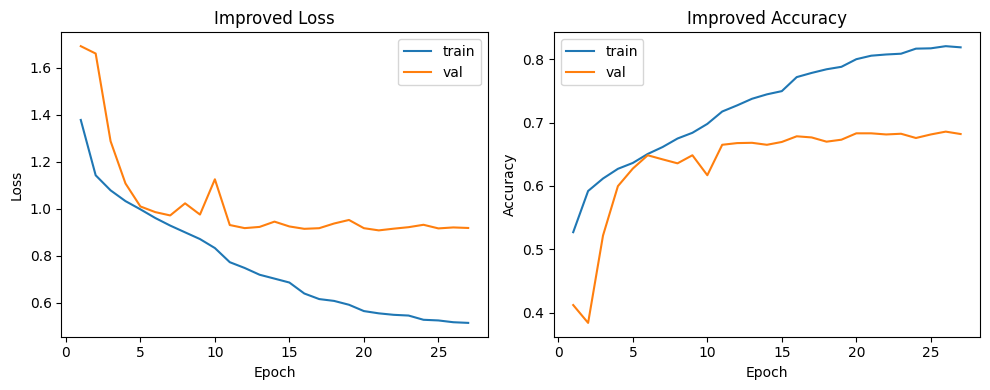

In [53]:
plot_history(hist_improved, title_prefix='Improved')


=== Validation (Improved) metrics (macro) ===
Accuracy: 0.3128
Precision (macro): 0.1293
Recall (macro): 0.1266
F1-score (macro): 0.1259

=== Validation (Improved) metrics (weighted) ===
Accuracy: 0.3128
Precision (weighted): 0.2932
Recall (weighted): 0.3128
F1-score (weighted): 0.3015


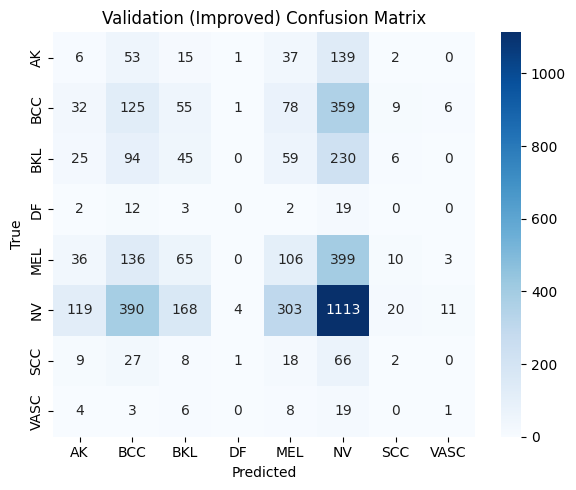

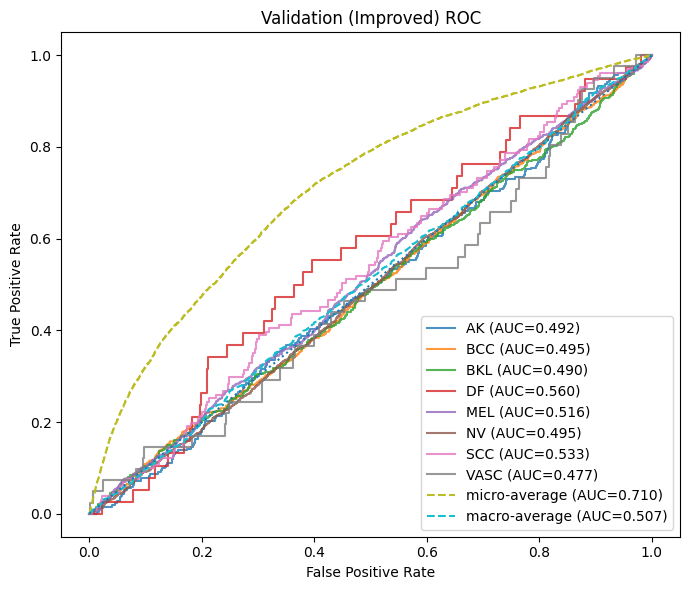


Classification report (per-class):

              precision    recall  f1-score   support

          AK       0.03      0.02      0.02       253
         BCC       0.15      0.19      0.17       665
         BKL       0.12      0.10      0.11       459
          DF       0.00      0.00      0.00        38
         MEL       0.17      0.14      0.16       755
          NV       0.47      0.52      0.50      2128
         SCC       0.04      0.02      0.02       131
        VASC       0.05      0.02      0.03        41

    accuracy                           0.31      4470
   macro avg       0.13      0.13      0.13      4470
weighted avg       0.29      0.31      0.30      4470



In [ ]:
full_evaluation(improved, test_data, split_name='Test (Improved)')

# 7. Transfer learning model

### 7.1 Design

In [64]:
def build_transfer_model(backbone='resnet50', target_size=(224, 224),
                         head_units=128, dropout=0.3):
    """
    Frozen feature extractor with an internal resize from (IMG_HEIGHT, IMG_WIDTH) to target_size.
    Works with your generators that already use rescale=1./255.
    """
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # 1) Resize using a Keras layer (not tf.image.resize on a KerasTensor)
    x = layers.Resizing(target_size[0], target_size[1], interpolation='bilinear')(inputs)

    # 2) Your datagen rescales to [0,1]; preprocess_input expects [0,255]
    x = layers.Lambda(lambda t: t * 255.0, name="undo_rescale")(x)

    # 3) Backbone-specific preprocessing and base model
    b = backbone.lower()
    if b == 'resnet50':
        x = layers.Lambda(resnet_pre, name="preprocess_resnet")(x)
        base = ResNet50(include_top=False, weights='imagenet',
                        input_shape=target_size + (3,))
    elif b == 'vgg16':
        x = layers.Lambda(vgg_pre, name="preprocess_vgg")(x)
        base = VGG16(include_top=False, weights='imagenet',
                     input_shape=target_size + (3,))
    elif b == 'densenet121':
        x = layers.Lambda(densenet_pre, name="preprocess_densenet")(x)
        base = DenseNet121(include_top=False, weights='imagenet',
                           input_shape=target_size + (3,))
    else:
        raise ValueError("Unsupported backbone. Use 'resnet50', 'vgg16', or 'densenet121'.")

    # 4) Freeze backbone
    base.trainable = False

    # 5) Feature extraction + small head
    z = base(x, training=False)
    z = layers.GlobalAveragePooling2D()(z)
    z = layers.Dense(head_units, activation='relu')(z)
    z = layers.Dropout(dropout)(z)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(z)

    model = models.Model(inputs, outputs, name=f"TL_{backbone.upper()}")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### 7.2 Train

In [65]:
tl_model = build_transfer_model(backbone='resnet50', target_size=(224,224), head_units=128, dropout=0.3)
hist_tl = train_model(tl_model, train_data, val_data, epochs=30, early_stopping=True)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 562s 4s/step - accuracy: 0.5781 - loss: 1.2076 - val_accuracy: 0.6416 - val_loss: 0.9893 - learning_rate: 0.0010
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 802s 6s/step - accuracy: 0.6164 - loss: 1.0745 - val_accuracy: 0.6494 - val_loss: 0.9697 - learning_rate: 0.0010
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 507s 4s/step - accuracy: 0.6294 - loss: 1.0249 - val_accuracy: 0.6577 - val_loss: 0.9274 - learning_rate: 0.0010
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 522s 4s/step - accuracy: 0.6413 - loss: 0.9939 - val_accuracy: 0.6566 - val_loss: 0.9181 - learning_rate: 0.0010
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 545s 4s/step - accuracy: 0.6421 - loss: 0.9759 - val_accuracy: 0.6707 - val_loss: 0.9040 - learning_rate: 0.0010
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 603s 4s/step - accuracy: 0.6506 - loss: 0.9609 - val_accuracy: 0.6696 - val_loss: 0.8832 - learning_rate: 0.0010
Epoch 7/30
140/140 ━━━━━━━━━━━━

### 7.3 Evaluation

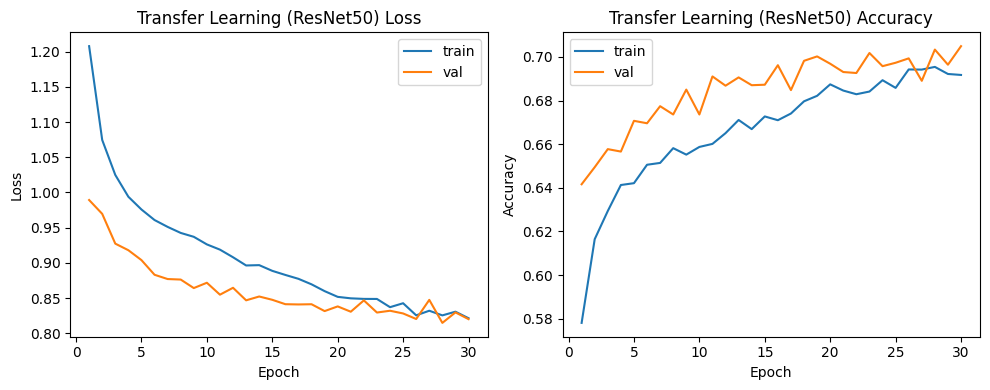

In [66]:
plot_history(hist_tl, title_prefix='Transfer Learning (ResNet50)')


=== Validation (TL) metrics (macro) ===
Accuracy: 0.3230
Precision (macro): 0.1230
Recall (macro): 0.1266
F1-score (macro): 0.1238

=== Validation (TL) metrics (weighted) ===
Accuracy: 0.3230
Precision (weighted): 0.2962
Recall (weighted): 0.3230
F1-score (weighted): 0.3080


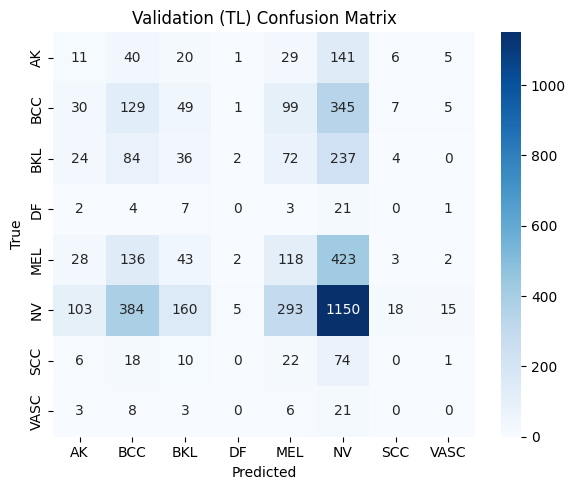

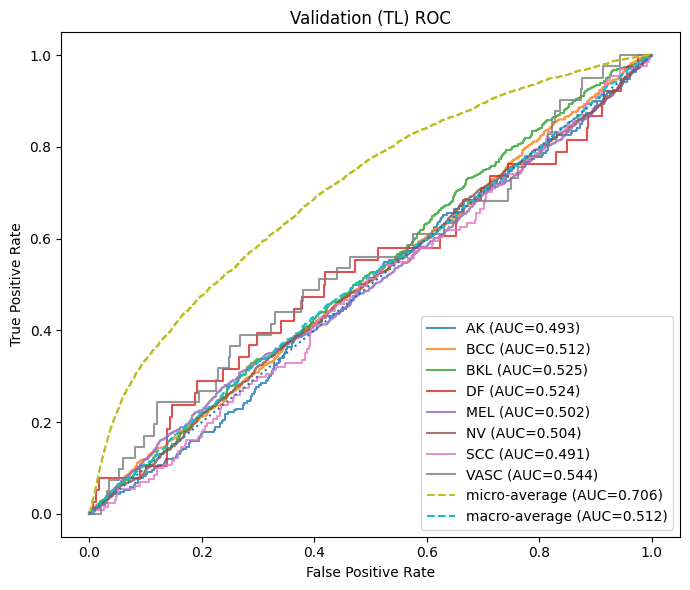


Classification report (per-class):

              precision    recall  f1-score   support

          AK       0.05      0.04      0.05       253
         BCC       0.16      0.19      0.18       665
         BKL       0.11      0.08      0.09       459
          DF       0.00      0.00      0.00        38
         MEL       0.18      0.16      0.17       755
          NV       0.48      0.54      0.51      2128
         SCC       0.00      0.00      0.00       131
        VASC       0.00      0.00      0.00        41

    accuracy                           0.32      4470
   macro avg       0.12      0.13      0.12      4470
weighted avg       0.30      0.32      0.31      4470



In [ ]:
full_evaluation(tl_model, test_data, split_name='Test (TL)')